calculte the mean of ROI Region

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ultralytics import YOLO

# Load your custom YOLO model
model_path = r"/home/gajendramandal/Result_analysis/best.pt"
model = YOLO(model_path)

# Load the video
video_path = r"/home/gajendramandal/Result_analysis/P01_2/thermal_rec_2.avi"
cap = cv2.VideoCapture(video_path)

# Get video properties
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))
print(f"FPS: {fps}")

# Output video writer
out = cv2.VideoWriter("output_video.avi", cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))

# Data storage
frame_numbers = []
mean_values = []

# Initialize previous mean pixel value
prev_mean_val = None  

# Plot setup
plt.ion()
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlim(0, 100)
ax.set_ylim(0, 255)
line, = ax.plot([], [], 'b-')  # Initialize an empty line plot

frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Run YOLO model
    results = model(frame)

    mean_val = None  # Reset mean for each frame
    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box
            conf = float(box.conf[0])  # Confidence score
            class_id = int(box.cls[0])  # Class ID
            class_name = model.names[class_id]  # Class name

            # Only process the "nostril" class
            if class_name == "nostril" and conf > 0.5:
                roi = frame[y1:y2, x1:x2]  # Extract nostril region
                mean_val = np.mean(roi)  # Compute mean pixel value

                # Draw bounding box and label
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, f"Nostril {conf:.2f}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # If no detection, use previous value
    if mean_val is None:
        if prev_mean_val is not None:
            mean_val = prev_mean_val  # Use previous frame's value
        else:
            mean_val = 0  # Default if no previous value exists

    # Store values
    frame_numbers.append(frame_count)
    mean_values.append(mean_val)
    prev_mean_val = mean_val  # Update previous value

    print(f"Frame {frame_count}: Mean Pixel Value = {mean_val}")

    frame_count += 1

    # Update plot in real-time
    # if len(frame_numbers) > 0:
    #     line.set_xdata(frame_numbers)
    #     line.set_ydata(mean_values)
    #     ax.relim()
    #     ax.autoscale_view()
    #     fig.canvas.draw()
    #     fig.canvas.flush_events()

    # # Show video with bounding boxes
    # cv2.imshow("YOLOv8 Detection", frame)
    # out.write(frame)

    # if cv2.waitKey(1) & 0xFF == ord('q'):
        # break

# Save data to CSV
df = pd.DataFrame({"Frame": frame_numbers, "Mean_Pixel_Value": mean_values})
df.to_csv(r"/home/gajendramandal/Result_analysis/P01_2/ex_2_mean_value.csv", index=False)

# Cleanup
cap.release()
out.release()
cv2.destroyAllWindows()
plt.ioff()
plt.show()


Resampling for gt data set


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

csv_path =r"/home/gajendramandal/Result_analysis/P01_4/Experiment4.csv"
dff = pd.read_csv(csv_path)

dff = dff.iloc[:, -3:-1]
dff.columns = ['Time(s)', 'Force']

dff.set_index('Time(s)', inplace=True)  # Set 'Time' as the index   dff["Time(s)"], dff["Force(N)"]

new_index = np.arange(0, dff.index[-1], 0.04)  # Create a new time index with intervals of 0.04

dff = dff.reindex(new_index).interpolate(method='linear') 

print(dff)
dff.to_csv('/home/gajendramandal/Result_analysis/P01_4/ex_4_gt_chest_resp.csv')

            Force
Time(s)          
0.00     6.216316
0.04     6.202519
0.08     6.188722
0.12     6.174925
0.16     6.161128
...           ...
670.08   6.579636
670.12   6.604164
670.16   6.628693
670.20   6.653221
670.24   6.653221

[16757 rows x 1 columns]


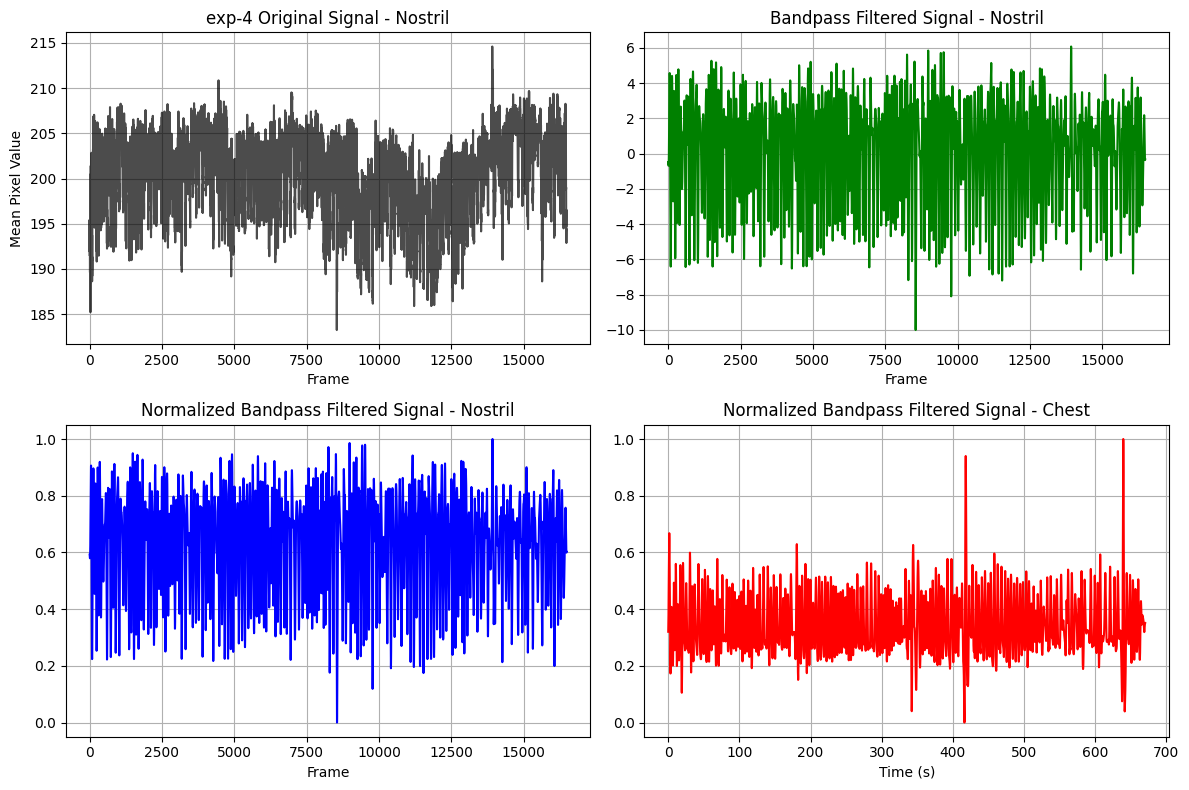

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler

# ====================== Load Data ======================
file_path_nostril=r"/home/gajendramandal/Result_analysis/P01_4/exp_4_mean_pixel_val.csv"
file_path_chest = r"/home/gajendramandal/Result_analysis/P01_4/ex_4_gt_chest_resp.csv"

# Load the CSV files
df_nostril = pd.read_csv(file_path_nostril)
df_chest = pd.read_csv(file_path_chest)

# Extract required columns
frames_nostril = df_nostril["Frame"].values
mean_values_nostril = df_nostril["Mean_Pixel_Value"].values

Time_chest = df_chest["Time(s)"].values
signal_chest = df_chest["Force"].values

# ====================== Define Bandpass Filter ======================

def butter_bandpass_filter(data, lowcut, highcut, fs=25, order=3):
    nyq = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# ====================== Apply Bandpass Filter ======================

# Define cutoff frequencies
lowcut = 0.1
highcut = 0.5

# Apply bandpass filter
band_passed_nostril = butter_bandpass_filter(mean_values_nostril, lowcut, highcut)
band_passed_chest = butter_bandpass_filter(signal_chest, lowcut, highcut)

# ====================== Normalize the Filtered Signal ======================

scaler = MinMaxScaler(feature_range=(0, 1))  # Normalize to range [0,1]

# Reshape for sklearn scaler
band_passed_nostril_normalized = scaler.fit_transform(band_passed_nostril.reshape(-1, 1)).flatten()
band_passed_chest_normalized = scaler.fit_transform(band_passed_chest.reshape(-1, 1)).flatten()

# ====================== Plot Results ======================

plt.figure(figsize=(12, 8))

# Original vs Filtered vs Normalized - Nostril
plt.subplot(2, 2, 1)
plt.plot(frames_nostril, mean_values_nostril, label="Original", color="black", alpha=0.7)
plt.title("exp-4 Original Signal - Nostril")
plt.xlabel("Frame")
plt.ylabel("Mean Pixel Value")
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(frames_nostril, band_passed_nostril, label="Bandpass Filtered", color="green")
plt.title("Bandpass Filtered Signal - Nostril")
plt.xlabel("Frame")
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(frames_nostril, band_passed_nostril_normalized, label="Normalized", color="blue")
plt.title("Normalized Bandpass Filtered Signal - Nostril")
plt.xlabel("Frame")
# plt.xlim([0,1500])
plt.grid()

# Original vs Filtered vs Normalized - Chest
plt.subplot(2, 2, 4)
plt.plot(Time_chest, band_passed_chest_normalized, label="Normalized", color="red")
plt.title("Normalized Bandpass Filtered Signal - Chest")
plt.xlabel("Time (s)")
# plt.xlim([0,60])
plt.grid()

plt.tight_layout()
plt.show()


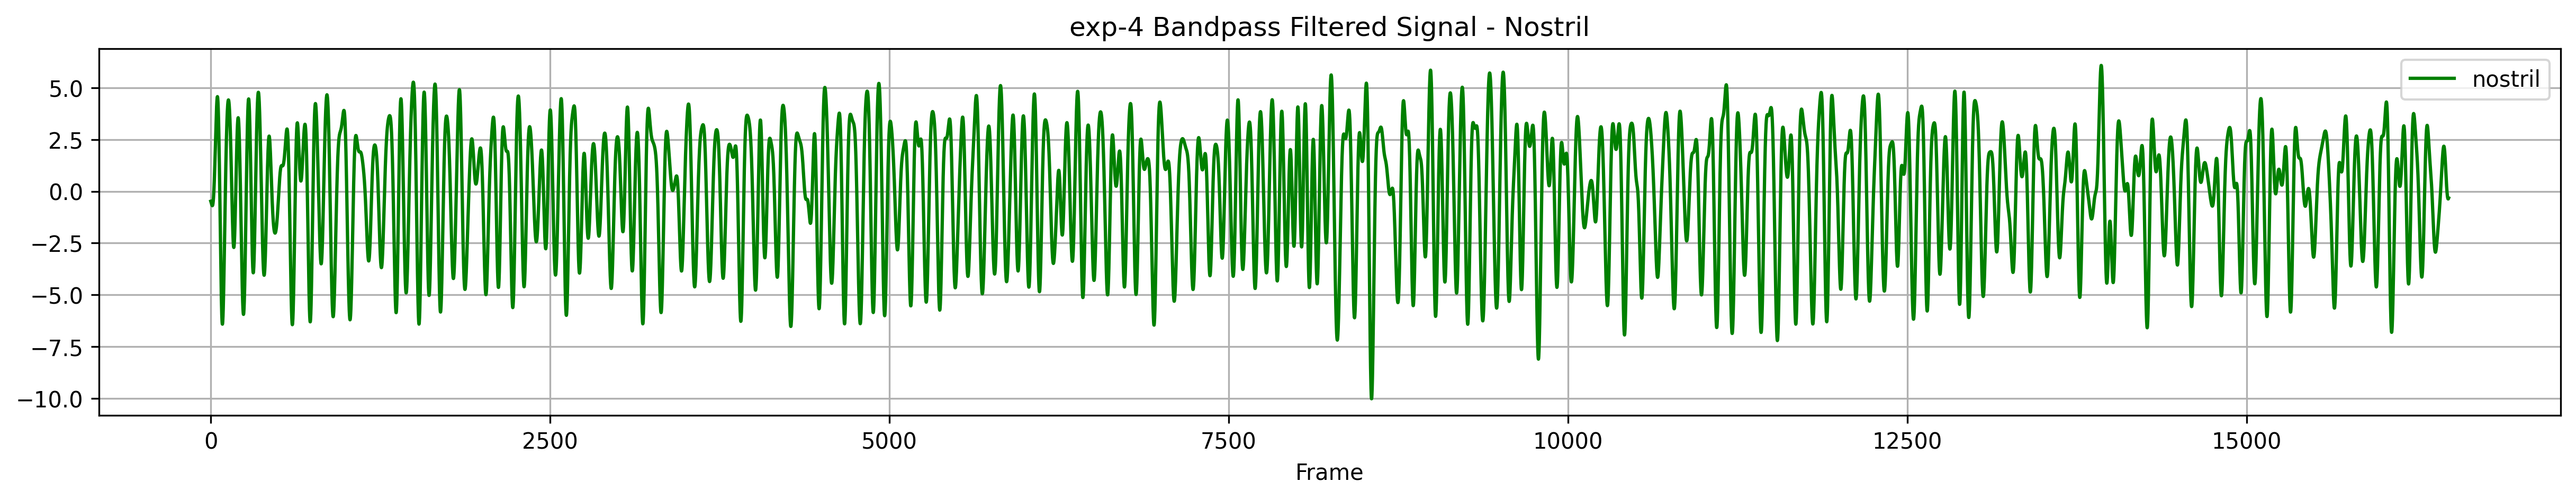

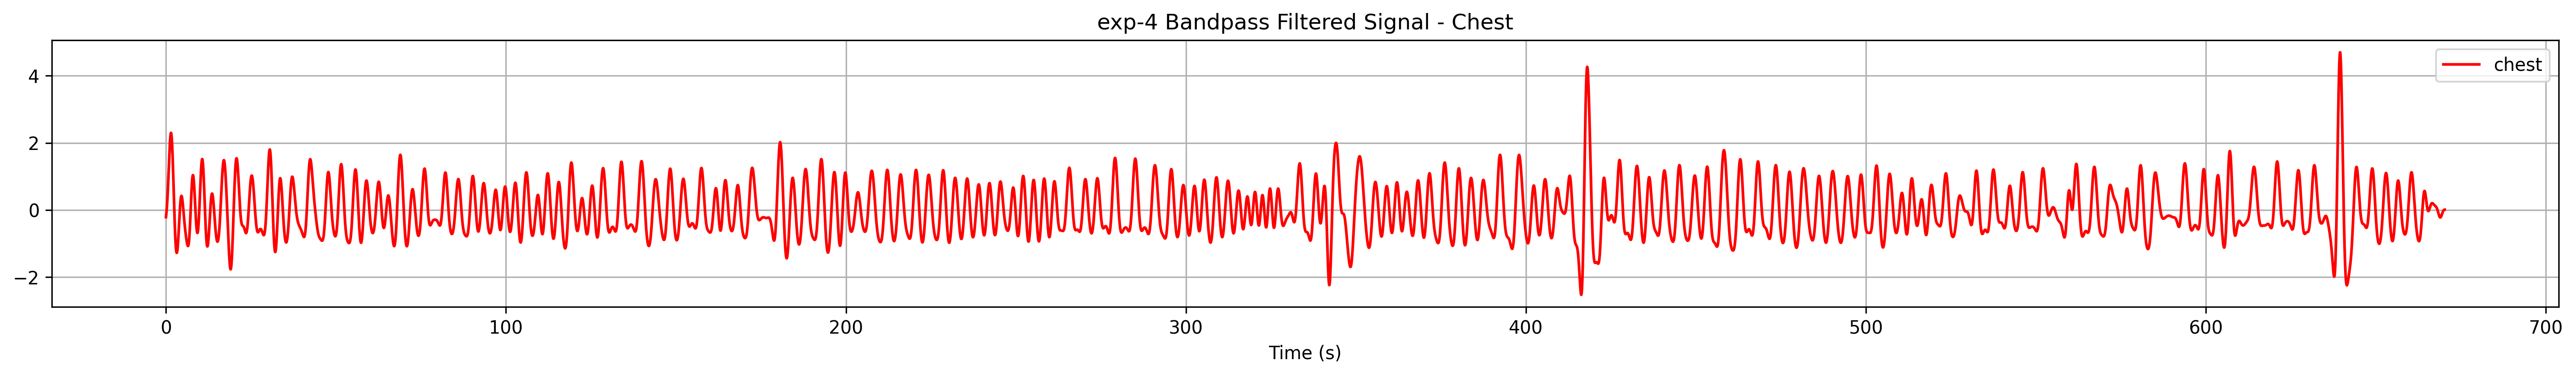

In [84]:

plt.figure(figsize=(20,3),dpi=300)
plt.plot(frames_nostril, band_passed_nostril, label="nostril", color="green")
plt.title("exp-4 Bandpass Filtered Signal - Nostril")
plt.xlabel("Frame")
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(20,3),dpi=300)
plt.plot(Time_chest, band_passed_chest, label="chest", color="red")
plt.title("exp-4 Bandpass Filtered Signal - Chest")
plt.xlabel("Time (s)")
# plt.xlim([0,60])
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


In [37]:
print(signal_chest)
print(band_passed_chest)

[9.43305969 9.09886627 8.76467285 ... 9.40086517 9.40239716 9.40239716]
[-0.25776578 -0.34818288 -0.43672784 ...  0.29460018  0.26035923
  0.22785617]


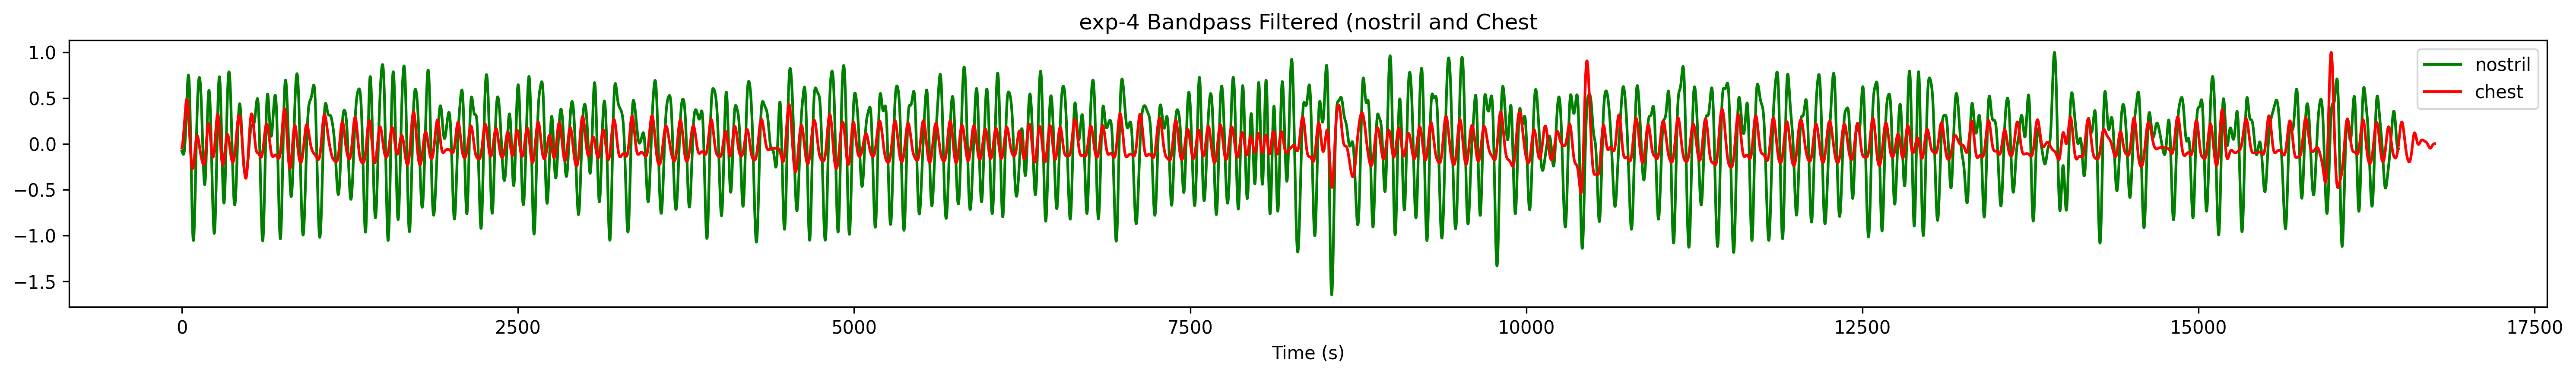

In [85]:
plt.figure(figsize=(20,3),dpi=300)
plt.plot(band_passed_nostril/max(band_passed_nostril), label="nostril", color="green")
plt.xlabel("Frame")
plt.grid()
plt.plot(band_passed_chest/max(band_passed_chest), label="chest", color="red")
plt.title("exp-4 Bandpass Filtered (nostril and Chest")
plt.xlabel("Time (s)")
plt.legend()

# plt.xlim([0,60])
plt.grid()

plt.tight_layout()
plt.show()

In [20]:
print(band_passed_chest/max(band_passed_chest))


[-0.05766293 -0.07788948 -0.09769724 ...  0.06590288  0.05824309
  0.05097206]


In [77]:

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score  # Import r2_score
import matplotlib.pyplot as plt


predicted = band_passed_nostril/max(band_passed_nostril)
ground_truth =band_passed_chest/max(band_passed_chest)

# print("ground_truth",band_passed_chest_normalized,"\n")
# print("orgjnal_predicted",band_passed_nostril_normalized,"\n")

# Normalize signals
ground_truth_normalized = (ground_truth - ground_truth.min()) / (ground_truth.max() - ground_truth.min())
# print("ground_truth_normalised",ground_truth_normalized,"\n")
predicted_normalized = (predicted - predicted.min()) / (predicted.max() - predicted.min())
# print("predicted_normalized",predicted_normalized,"\n")

# Define window parameters
sampling_rate = 25  # in Hz
window_duration = 20  # in seconds
window_size = window_duration * sampling_rate  # Number of samples per window

# Split into windows
num_samples = len(ground_truth_normalized)
ground_truth_windows = []
predicted_windows = []

for start in range(0, num_samples, window_size):
    end = start + window_size
    if end <= num_samples: 
        ground_truth_windows.append(ground_truth_normalized[start:end])
        predicted_windows.append(predicted_normalized[start:end])



# # Remove the last element
# if len(predicted_windows[-1]) != 500:
#     predicted_windows.pop()

# Convert to NumPy array
predicted_windows = np.array(predicted_windows)

# Verify the shape
print(predicted_windows.shape)
print(len(predicted_windows))
print([len(sublist) for sublist in predicted_windows])


print("thsi is for gt")

# if len(ground_truth_windows[-1]) == 500:
#     ground_truth_windows.pop()

#Convert lists to numpy arrays
ground_truth_windows = np.array(ground_truth_windows)

print(ground_truth_windows.shape)
print(len(ground_truth_windows))
print([len(sublist) for sublist in ground_truth_windows])
print(ground_truth_windows)


(36, 500)
36
[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]
thsi is for gt
(36, 500)
36
[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]
[[0.42176293 0.4244621  0.42732123 ... 0.59495697 0.61812906 0.64066033]
 [0.66234904 0.68299369 0.7023953  ... 0.46511858 0.45787944 0.45052802]
 [0.4431098  0.43566748 0.42824071 ... 0.37291728 0.37519726 0.37730058]
 ...
 [0.40107527 0.40121391 0.40137301 ... 0.3748239  0.37458338 0.37431953]
 [0.37402284 0.37368594 0.37330371 ... 0.27175384 0.26835322 0.26511926]
 [0.26207195 0.25923542 0.25663803 ... 0.46170919 0.45859229 0.455247  ]]


window split without normalization

In [ ]:

# import pandas as pd
# import numpy as np
# from sklearn.metrics import r2_score  # Import r2_score
# import matplotlib.pyplot as plt


# predicted = band_passed_nostril/max(band_passed_nostril)
# ground_truth =band_passed_chest/max(band_passed_chest)



# # Define window parameters
# sampling_rate = 25  # in Hz
# window_duration = 20  # in seconds
# window_size = window_duration * sampling_rate  # Number of samples per window

# # Split into windows
# num_samples = len(ground_truth)
# ground_truth_windows = []
# predicted_windows = []

# for start in range(0, num_samples, window_size):
#     end = start + window_size
#     if end <= num_samples: 
#         ground_truth_windows.append(ground_truth[start:end])
#         predicted_windows.append(predicted[start:end])



# # Remove the last element
# if len(predicted_windows[-1]) != 500:
#     predicted_windows.pop()

# # Convert to NumPy array
# predicted_windows = np.array(predicted_windows)

# # Verify the shape
# print(predicted_windows.shape)
# print(len(predicted_windows))
# print([len(sublist) for sublist in predicted_windows])


# print("thsi is for gt")

# if len(ground_truth_windows[-1]) == 500:
#     ground_truth_windows.pop()

# #Convert lists to numpy arrays
# ground_truth_windows = np.array(ground_truth_windows)

# print(ground_truth_windows.shape)
# print(len(ground_truth_windows))
# print([len(sublist) for sublist in ground_truth_windows])
# print(ground_truth_windows)


In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
import pandas as pd

sampling_rate = 25  # Sampling rate in Hz

windows = ground_truth_windows#ground_truth_windows_list
windows_p= predicted_windows#predicted_windows_list

# Step 3: Calculate the dominant frequency in each window
dominant_frequencies = []
dominant_frequencies_p=[]

for i, window in enumerate(windows):
    frequencies, power_spectrum = periodogram(window, fs=sampling_rate)
    dominant_frequency = frequencies[np.argmax(power_spectrum)]
    dominant_frequencies.append(dominant_frequency)

for i, window in enumerate(windows_p):
    frequencies_1, power_spectrum_1 = periodogram(window, fs=sampling_rate)
    dominant_frequency_1 = frequencies_1[np.argmax(power_spectrum_1)]
    dominant_frequencies_p.append(dominant_frequency_1)

# Print the dominant frequencies for each window
for i, freq in enumerate(dominant_frequencies):
    print(f"Window {i + 1}: Dominant Frequency gt = {freq} Hz")
for i, freq in enumerate(dominant_frequencies_p):
    print(f"Window {i + 1}: Dominant Frequency pre = {freq} Hz")    
    
# #save into csv
# csv_file=pd.DataFrame({
#     'window':np.arange(1,len(windows)+1),
#     'dom_fre_gt':dominant_frequencies,
#     'dom_fre_pre':dominant_frequencies_p,
# })
# csv_file.to_csv("/home/gajendramandal/Result_analysis/P01_4/ex_4_dominant_frequencies.csv",index=False)

Window 1: Dominant Frequency gt = 0.15000000000000002 Hz
Window 2: Dominant Frequency gt = 0.2 Hz
Window 3: Dominant Frequency gt = 0.15000000000000002 Hz
Window 4: Dominant Frequency gt = 0.25 Hz
Window 5: Dominant Frequency gt = 0.2 Hz
Window 6: Dominant Frequency gt = 0.25 Hz
Window 7: Dominant Frequency gt = 0.2 Hz
Window 8: Dominant Frequency gt = 0.30000000000000004 Hz
Window 9: Dominant Frequency gt = 0.15000000000000002 Hz
Window 10: Dominant Frequency gt = 0.30000000000000004 Hz
Window 11: Dominant Frequency gt = 0.30000000000000004 Hz
Window 12: Dominant Frequency gt = 0.30000000000000004 Hz
Window 13: Dominant Frequency gt = 0.15000000000000002 Hz
Window 14: Dominant Frequency gt = 0.15000000000000002 Hz
Window 15: Dominant Frequency gt = 0.2 Hz
Window 16: Dominant Frequency gt = 0.2 Hz
Window 17: Dominant Frequency gt = 0.30000000000000004 Hz
Window 18: Dominant Frequency gt = 0.35000000000000003 Hz
Window 19: Dominant Frequency gt = 0.15000000000000002 Hz
Window 20: Domina

In [79]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score  # Import r2_score
import matplotlib.pyplot as plt


file=pd.read_csv(r"/home/gajendramandal/Result_analysis/P01_3/ex_3_dominant_frequencies.csv")

print(file["dom_fre_gt"].values)
print(file["dom_fre_pre"].values)

ground_truth_windows=file["dom_fre_gt"].values
predicted_windows=file["dom_fre_pre"].values
window_no=file["window"].values

# Calculate error metrics per window
mae_per_window = []
rmse_per_window = []

for gt_window, pred_window in zip(ground_truth_windows, predicted_windows):
    mae = np.mean(np.abs(gt_window - pred_window))  # Mean Absolute Error (MAE)
    rmse = np.sqrt(np.mean((gt_window - pred_window) ** 2))  # Root Mean Square Error (RMSE)

          
    mae_per_window.append(mae)
    rmse_per_window.append(rmse)

mean_MAE=np.mean(mae_per_window)
# print("mean of MAE",mean_MAE)
print("mean of MAE",round(mean_MAE,2))
mean_RMSE=np.mean(rmse_per_window)
# print("mean of RMSE",mean_RMSE)
print("mean of RMSE",round(mean_RMSE,2))

#save into csv
csv_file=pd.DataFrame({
    'window':np.arange(1,len(windows)+1),
    'dom_fre_gt':dominant_frequencies,
    'dom_fre_pre':dominant_frequencies_p,
    'mae_per_window':mae_per_window,
    'rmse_per_window':rmse_per_window,
    "mean of MAE":round(mean_MAE,2),
    "mean of RMSE":round(mean_RMSE,2),
})
csv_file.to_csv("/home/gajendramandal/Result_analysis/P01_3/ex_3_result.csv",index=False)


[0.15 0.2  0.15 0.25 0.2  0.25 0.2  0.3  0.15 0.3  0.3  0.3  0.15 0.15
 0.2  0.2  0.3  0.35 0.15 0.25 0.3  0.25 0.3  0.2  0.2  0.2  0.2  0.15
 0.25 0.15 0.15 0.15 0.15 0.15 0.25 0.3 ]
[0.2  0.3  0.15 0.35 0.35 0.25 0.2  0.3  0.3  0.3  0.15 0.3  0.15 0.15
 0.2  0.2  0.25 0.2  0.4  0.35 0.25 0.2  0.15 0.2  0.2  0.2  0.15 0.2
 0.25 0.3  0.35 0.25 0.3  0.15 0.25 0.15]
mean of MAE 0.07
mean of RMSE 0.07
